In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import gzip
import pickle


In [2]:
# Function to load data from a .gz file
def load_from_gz(filename):
    with gzip.open(filename, 'rb') as f:
        data = pickle.load(f)
    return data

# Load the data
loaded_images = load_from_gz('colored_mnist_images.gz')
loaded_targets = load_from_gz('colored_mnist_targets.gz')


In [3]:

class ColoredMNISTDataset(Dataset):
    def __init__(self, images, targets, transform=None):
        self.images = images
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        image = self.images[idx]
        target = self.targets[idx]
        if self.transform:
            image = self.transform(torch.tensor(image))
        return image, target

def replace_gray_with_white(img):
    img_np = img.numpy()  # Convert tensor to numpy array
    threshold = 0.11 # Example threshold to determine gray pixels

    # Iterate over the image and replace gray pixels with white
    img_np[(img_np >= threshold)] = 1  # Replace with white (1.0)

    return torch.from_numpy(img_np)  # Convert back to tensor


# Transform pipeline including custom transformation
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Lambda(replace_gray_with_white),
    transforms.RandomRotation(degrees=(-180,180)),
    torchvision.transforms.GaussianBlur(3, sigma=(0.1, 2.0)),
    torchvision.transforms.RandomErasing(p=0.5, scale=(0.02, 0.05), ratio=(0.3, 3.3), value=0, inplace=False)
])


batch_size = 64

# Create the new dataset
train_dataset = ColoredMNISTDataset(loaded_images, loaded_targets, transform=transform)

# Create a DataLoader for the new dataset
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


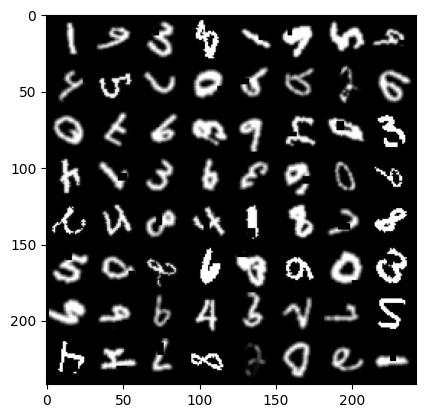

    1     6     3     8     1     6     5     9


In [4]:
# Function to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))

# Print labels
print(' '.join('%5s' % labels[j].item() for j in range(8)))

In [5]:
class ColoredNet(nn.Module):
    def __init__(self):
        super(ColoredNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)  # Flatten the input
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

net = ColoredNet()

img=train_dataset[0][0]
summary(net, input_size = img.size())


Layer (type:depth-idx)                   Output Shape              Param #
ColoredNet                               [1, 10]                   --
├─Conv2d: 1-1                            [32, 28, 28]              320
├─ReLU: 1-2                              [32, 28, 28]              --
├─MaxPool2d: 1-3                         [32, 14, 14]              --
├─Conv2d: 1-4                            [64, 14, 14]              18,496
├─ReLU: 1-5                              [64, 14, 14]              --
├─MaxPool2d: 1-6                         [64, 7, 7]                --
├─Linear: 1-7                            [1, 512]                  1,606,144
├─ReLU: 1-8                              [1, 512]                  --
├─Dropout: 1-9                           [1, 512]                  --
├─Linear: 1-10                           [1, 256]                  131,328
├─ReLU: 1-11                             [1, 256]                  --
├─Dropout: 1-12                          [1, 256]                  -

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)


In [23]:
num_epochs = 3


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net=net.to(device)

for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in tqdm(train_dataloader):
        optimizer.zero_grad()
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = net(inputs.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_dataloader)}")



100%|██████████| 938/938 [02:24<00:00,  6.50it/s]


Epoch 1, Loss: 0.567089275891847


100%|██████████| 938/938 [02:28<00:00,  6.33it/s]


Epoch 2, Loss: 0.3020573111374114


100%|██████████| 938/938 [23:39<00:00,  1.51s/it]   

Epoch 3, Loss: 0.241544882895977


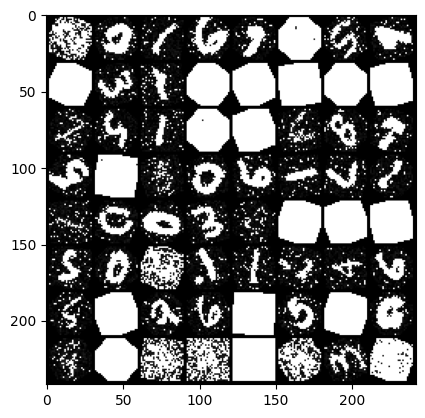

In [8]:

loaded_test_images = load_from_gz('colored_mnist_test_images_hard.gz')


class TestMNISTDataset(Dataset):
    def __init__(self, images, transform = None):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        if self.transform:
            image = self.transform(torch.tensor(image))
        return image
    
transform_test = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Lambda(replace_gray_with_white)
])


# Create the new dataset
test_dataset = TestMNISTDataset(loaded_test_images, transform_test)

# Create a DataLoader for the new dataset
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


test_dataiter = iter(test_dataloader)
test_images = next(test_dataiter)

imshow(torchvision.utils.make_grid(test_images))

In [57]:

predictions=[]

for img in test_dataloader :
    img = img.to(device)
    l=np.array(net(img.float()).tolist())
    predicted=[]
    for i in range(len(l)) :
        predicted.append(np.argmax(l[i]))
    predictions.extend(predicted)


np.save('predictions.npy', predictions)